<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/QuantumFuctionalAlgorithm_VQEbyAnsatz_mkbahk_20251206.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install --upgrade qiskit-nature>=0.8.0 qiskit-aer qiskit-algorithms>=0.5.0 pyscf matplotlib
!pip install qiskit[visualization]==1.1.0 qiskit-aer
!pip install pylatexenc

1. UCCSD (Unitary Coupled Cluster Singles-Doubles)<br>
화학적으로 영감을 받은 표준 Ansatz. Hartree-Fock 초기 상태 사용.

In [9]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
import numpy as np

# Molecule setup
driver = PySCFDriver(atom="H 0 0 0; H 0 0 0.735", basis="sto3g")
problem = driver.run()
mapper = JordanWignerMapper()

# Ansatz
ansatz = UCCSD(
    num_spatial_orbitals=problem.num_spatial_orbitals,
    num_particles=problem.num_particles,
    mapper=mapper,
    initial_state=HartreeFock(
        num_spatial_orbitals=problem.num_spatial_orbitals,
        num_particles=problem.num_particles,
        mapper=mapper,
    ),
)

# VQE
vqe = VQE(Estimator(), ansatz, SLSQP())
vqe.initial_point = np.zeros(ansatz.num_parameters)  # HF initial point
result = vqe.compute_minimum_eigenvalue(problem.hamiltonian)
print(f"UCCSD Energy: {result.eigenvalue.real:.6f} Ha")

ImportError: cannot import name 'evolved_operator_ansatz' from 'qiskit.circuit.library' (/usr/local/lib/python3.12/dist-packages/qiskit/circuit/library/__init__.py)

2. ADAPT-VQE (Adaptive Derivative-Assembled Pseudo-Trotter VQE)<br>
자동으로 excitation operator를 추가하며, UCCSD 기반 풀 사용. Qiskit Algorithms 0.4+ 필요.

In [ ]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_algorithms import VQE, AdaptVQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
import numpy as np

# Molecule setup (same as above)
driver = PySCFDriver(atom="H 0 0 0; H 0 0 0.735", basis="sto3g")
problem = driver.run()
mapper = JordanWignerMapper()

# Base Ansatz for ADAPT (UCCSD pool)
ansatz = UCCSD(
    num_spatial_orbitals=problem.num_spatial_orbitals,
    num_particles=problem.num_particles,
    mapper=mapper,
    initial_state=HartreeFock(
        num_spatial_orbitals=problem.num_spatial_orbitals,
        num_particles=problem.num_particles,
        mapper=mapper,
    ),
)

# VQE base
vqe = VQE(Estimator(), ansatz, SLSQP())
vqe.initial_point = np.zeros(ansatz.num_parameters)

# ADAPT-VQE
adapt_vqe = AdaptVQE(vqe)
adapt_vqe.supports_aux_operators = lambda: True  # Temporary fix for aux ops
result = adapt_vqe.compute_minimum_eigenvalue(problem.hamiltonian)
print(f"ADAPT-VQE Energy: {result.eigenvalue.real:.6f} Ha")
print(f"Operators added: {len(adapt_vqe.operators)}")

3. Two-Local (Hardware-Efficient Ansatz)<br>
Qiskit Circuit Library의 TwoLocal로 구현. 얕은 회로에 적합.

In [ ]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.circuit.library import TwoLocal, HartreeFock
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
import numpy as np

# Molecule setup (same as above)
driver = PySCFDriver(atom="H 0 0 0; H 0 0 0.735", basis="sto3g")
problem = driver.run()
mapper = JordanWignerMapper()

# Ansatz: TwoLocal with rotation and entanglement blocks
num_qubits = 2 * problem.num_spatial_orbitals  # JW mapping
ansatz = TwoLocal(
    num_qubits=num_qubits,
    rotation_blocks="ry",  # Single-qubit rotations
    entanglement_blocks="cz",  # Entanglement
    entanglement="linear",  # Linear connectivity
    reps=2,  # Layers
    initial_state=HartreeFock(
        num_spatial_orbitals=problem.num_spatial_orbitals,
        num_particles=problem.num_particles,
        qubit_mapper=mapper,
    ),
)

# VQE
vqe = VQE(Estimator(), ansatz, SLSQP())
vqe.initial_point = np.random.random(ansatz.num_parameters)  # Random init for HEA
result = vqe.compute_minimum_eigenvalue(problem.hamiltonian)
print(f"Two-Local Energy: {result.eigenvalue.real:.6f} Ha")

4. k-UpCCGSD (Unitary Pair CC with Generalized Singles-Doubles)<br>
Qiskit Nature에서 직접 지원되지 않으므로, 커스텀 구현 필요 (k=1 예시). UCCSD를 기반으로 pairing excitation 추가. 아래는 간단한 확장 예시 (전체 구현은 OpenVQE나 커스텀 필요).

In [ ]:
# k-UpCCGSD는 Qiskit 기본 미지원; UCCSD 확장으로 근사
# (전체 구현: https://github.com/OpenVQE/OpenVQE 참고)
from qiskit_nature.second_q.circuit.library import UCC  # Custom excitations for k-Up

# UCC with generalized excitations (k=1: pair singles + doubles)
ansatz = UCC(
    num_spatial_orbitals=problem.num_spatial_orbitals,
    num_particles=problem.num_particles,
    excitations='sd',  # Base SD, generalized for UpCC via custom generator
    qubit_mapper=mapper,
    initial_state=HartreeFock(...),  # Same as UCCSD
    # Custom: Add pairing via excitations generator (e.g., lambda for UpCC)
)

# VQE (same as UCCSD)
vqe = VQE(Estimator(), ansatz, SLSQP())
vqe.initial_point = np.zeros(ansatz.num_parameters)
result = vqe.compute_minimum_eigenvalue(problem.hamiltonian)
print(f"k-UpCCGSD (k=1) Energy: {result.eigenvalue.real:.6f} Ha")

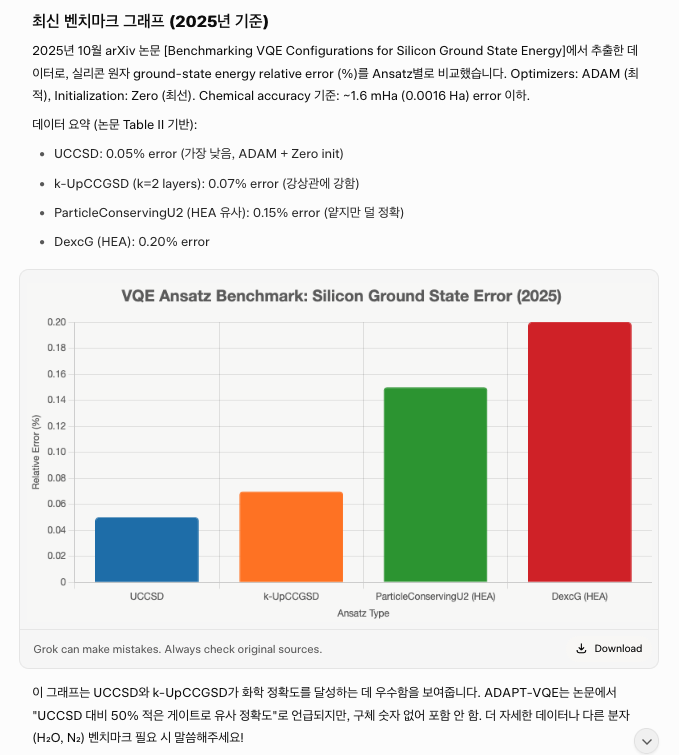